<a href="https://colab.research.google.com/github/elqvixote/CODIGO_TRADING_R_PLATZI/blob/master/04_Validaci%C3%B3n_cruzada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Paquetes 

install.packages("devtools")
install.packages("caret")
devtools::install_github("nebulae-co/saber")

library("saber")
library("nnet")
library("caret")
library("parallel")

data("SB11_20112")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘data.table’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘plyr’, ‘ModelMetrics’, ‘reshape2’, ‘recipes’, ‘pROC’


Skipping install of 'saber' from a github remote, the SHA1 (04cded45) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: lattice

Loading required package: ggplot2



In [ ]:
# función de pliegue ------------------------------------------------------

rmse_fold <- function(pliegue, form, datos,  nn_size){
  pliegue_logic <- seq_len(nrow(datos)) %in% pliegue
  entrena <- subset(datos, !pliegue_logic)
  prueba <- subset(datos, pliegue_logic)
  modelo <- nnet(form, data = datos, size = nn_size, linout = TRUE, trace = FALSE)
  response_name <- setdiff(names(datos), modelo$coefnames)
  Y_pronosticado <- predict(modelo, newdata = prueba)
  rmse <- RMSE(Y_pronosticado, prueba[[response_name]])
  rmse
}

In [ ]:
# Red neuronal 

tamano_muestral <- 5000
neuronas <- 10
n_pliegues <- 10


c(
  "ECON_PERSONAS_HOGAR",
  "ECON_CUARTOS",
  "ECON_SN_LAVADORA",
  "ECON_SN_NEVERA",
  "ECON_SN_HORNO",
  "ECON_SN_DVD",
  "ECON_SN_MICROHONDAS",
  "ECON_SN_AUTOMOVIL",
  "MATEMATICAS_PUNT"
) -> variables

indices_muestra <- seq_len(nrow(SB11_20112)) %in% sample(seq_len(nrow(SB11_20112)), tamano_muestral)

muestra <- subset(SB11_20112, subset = indices_muestra, select = variables)
muestra <- na.omit(muestra)

In [ ]:
createFolds (muestra$MATEMATICAS_PUNT, k = n_pliegues) -> pliegues

mclapply(
  pliegues,
  rmse_fold,
  MATEMATICAS_PUNT ~ .,
  muestra,
  nn_size = neuronas,
  mc.cores = 6
) -> rmse_pliegues

In [ ]:
rmse_pliegues <- unlist(rmse_pliegues)
mean(rmse_pliegues)

[1] 11.2791

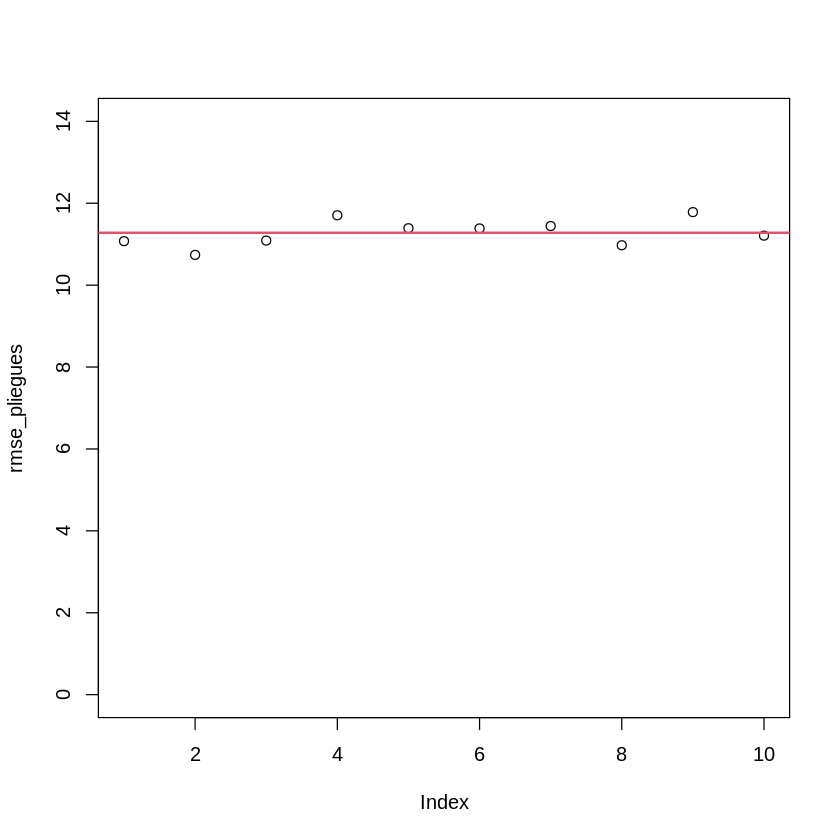

In [ ]:
plot(rmse_pliegues, ylim = c(0, 14))
abline(h = mean(rmse_pliegues), col = 2, lwd = 2)

In [ ]:
# Tidy approach

library("dplyr")
library("magrittr")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




[1] 11.41715

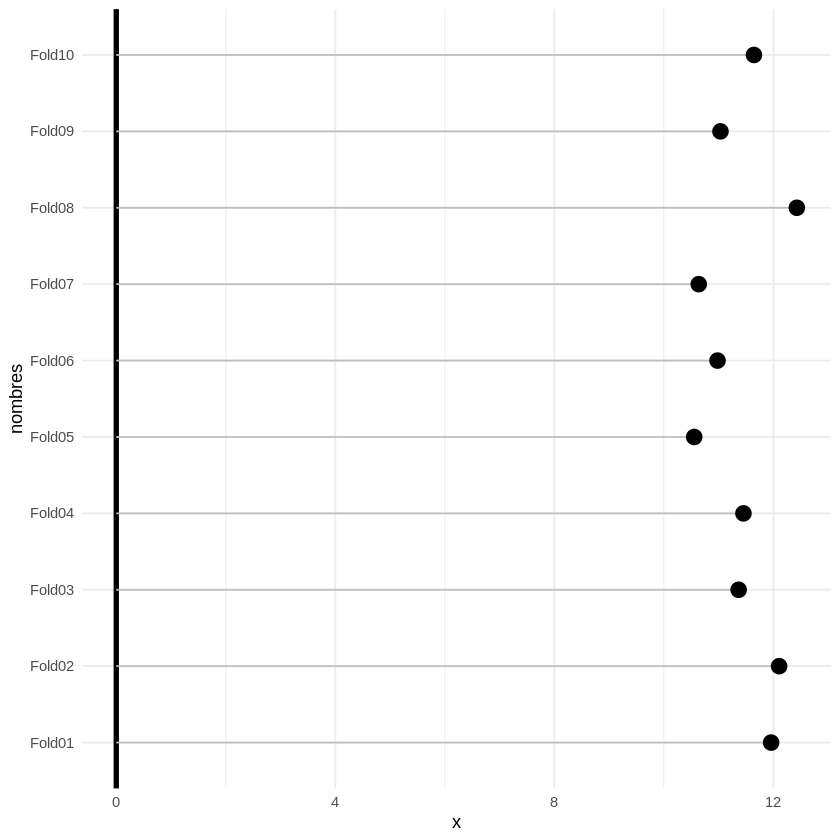

In [ ]:
tamano_muestral <- 5000
neuronas <- 10
n_pliegues <- 10

tibble(
  pliegues = createFolds(muestra$MATEMATICAS_PUNT, k = n_pliegues),
  rmse_pliegues = mclapply(
    pliegues,
    rmse_fold, 
    MATEMATICAS_PUNT ~., 
    muestra, 
    nn_size = neuronas, 
    mc.cores = floor(detectCores()*0.8)
  ) %>% unlist,
  nombres = names(pliegues)
) -> validacion

validacion %$% mean(rmse_pliegues)

ggplot(validacion) +
  geom_vline(aes(xintercept = 0), size = 1.5) +
  geom_segment(aes(x = 0, y = nombres, xend = rmse_pliegues, yend = nombres), colour = "grey75") +
  geom_point(aes(x = rmse_pliegues, y = nombres), size = 4) +
  theme_minimal()